In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import os
import datetime as dt
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')
%config IPCompleter.greedy=True

In [3]:
#Setting up graph standards
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Table of Contents

   * [Data Loading](#data_load)
   * [Demand Exploration](#demands)
   * [Response Exploration](#responses)
   * [Country Exploration](#country)
   * [Region Exploration](#region)
   * [Year Exploration](#year)
   * [Duration Exploration](#duration)
   * [Season Exploration](#season)
   * [Participant Category Exploration](#part_category)
   * [Multidemand Exploration](#multidemands)
   * [Multiresponse Exploration](#multiresponse)
   * [Protestor Violence Exploration](#prot_violence)
   * [Stacked graph for State responses](#stack)
   * [Cramers V Correlation](#cramers)

## Data loading <a class="anchor" id="data_load"></a>

This section covers the importing of the data and the column type casting 

In [6]:
df = pd.read_csv('../notebooks/df.csv')

In [7]:
df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,protesterdemand2_y,protesterdemand3_y,protesterdemand4_y,stateresponse1_y,stateresponse2_y,stateresponse3_y,stateresponse4_y,stateresponse5_y,stateresponse6_y,stateresponse7_y
0,201990001,Canada,20,1990,North America,1,1,15.0,1.0,1990.0,...,labor wage dispute,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN
1,201990002,Canada,20,1990,North America,1,2,25.0,6.0,1990.0,...,NaN,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN
2,201990003,Canada,20,1990,North America,1,3,1.0,7.0,1990.0,...,NaN,NaN,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN
3,201990004,Canada,20,1990,North America,1,4,12.0,7.0,1990.0,...,NaN,NaN,NaN,accomodation,NaN,NaN,NaN,NaN,NaN,NaN
4,201990005,Canada,20,1990,North America,1,5,14.0,8.0,1990.0,...,NaN,NaN,NaN,crowd dispersal,arrests,accomodation,NaN,NaN,NaN,NaN


In [9]:
#Creating a dictionary of column:dtype
df_cat_dict = {
"region" : 'category',
"startmonth" : 'category',
"endmonth" : 'category',
"new_participants_category" : 'category',
"labor_wage_dispute" : 'bool',
"land_farm_issue" : 'bool',
"police_brutality" : 'bool',
"political_behavior" : 'bool',
"price_increases_tax_policy" : 'bool',
"removal_of_politician" : 'bool',
"social_restrictions" : 'bool',
"accomodation" : 'bool',
"arrests" : 'bool',
"beatings" : 'bool',
"crowd_dispersal" : 'bool',
"ignore" : 'bool',
"killings" : 'bool',
"shootings" : 'bool',
"first_response" : 'category',
"last_response" : 'category',
"protesterdemand1_y" : 'category',
"protesterdemand2_y" : 'category',
"protesterdemand3_y" : 'category',
"protesterdemand4_y" : 'category',
"stateresponse1_y" : 'category',
"stateresponse2_y" : 'category',
"stateresponse3_y" : 'category',
"stateresponse4_y" : 'category',
"stateresponse5_y" : 'category',
"stateresponse6_y" : 'category',
"stateresponse7_y" : 'category',
"year" : 'int',
"startday" : 'int',
"startyear" : 'int',
"endday" : 'int',
"endyear" : 'int',
"protesterviolence" : 'int',
"start_date": 'datetime64[ns]',
"end_date": 'datetime64[ns]',
"protesterviolence" :'bool'
}

In [10]:
df = df.astype(df_cat_dict)

In [11]:
#confirming previous step worked as expected
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14482 entries, 0 to 14481
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          14482 non-null  int64         
 1   country                     14482 non-null  object        
 2   ccode                       14482 non-null  int64         
 3   year                        14482 non-null  int64         
 4   region                      14482 non-null  category      
 5   protest                     14482 non-null  int64         
 6   protestnumber               14482 non-null  int64         
 7   startday                    14482 non-null  int64         
 8   startmonth                  14482 non-null  category      
 9   startyear                   14482 non-null  int64         
 10  endday                      14482 non-null  int64         
 11  endmonth                    14482 non-null  category  

Next I create df2, a dataframe that only contains the features and the target columns. Examples of columns that will not be included: 'id', 'ccode', 'protest','location', 'sources', 'notes', etc..

In [14]:
df2 = df[['country','region','year','startmonth','participants_int','new_participants_category', 'labor_wage_dispute','land_farm_issue','police_brutality','political_behavior','price_increases_tax_policy','removal_of_politician','social_restrictions','protesterdemand1_y','protesterdemand2_y','protesterdemand3_y','protesterdemand4_y','stateresponse1_y', 'stateresponse2_y', 'stateresponse3_y','stateresponse4_y','stateresponse5_y','stateresponse6_y','stateresponse7_y','accomodation','arrests','beatings','crowd_dispersal','ignore','killings','shootings','first_response','last_response','demands_count','responses_count','start_date','end_date', 'protesterviolence']]

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14482 entries, 0 to 14481
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   country                     14482 non-null  object        
 1   region                      14482 non-null  category      
 2   year                        14482 non-null  int64         
 3   startmonth                  14482 non-null  category      
 4   participants_int            14465 non-null  float64       
 5   new_participants_category   14465 non-null  category      
 6   labor_wage_dispute          14482 non-null  bool          
 7   land_farm_issue             14482 non-null  bool          
 8   police_brutality            14482 non-null  bool          
 9   political_behavior          14482 non-null  bool          
 10  price_increases_tax_policy  14482 non-null  bool          
 11  removal_of_politician       14482 non-null  bool      

## Protester Demand Breakdown <a class="anchor" id="demands"></a>

Creating a dataframe that specifies the percentage of each demand in the dataset in order to see the breakdown of protester demands.

In [17]:
dem_total = df.demands_count.sum()
dem_columns = ["labor_wage_dispute","land_farm_issue","police_brutality","political_behavior","price_increases_tax_policy","removal_of_politician","social_restrictions"]
dem_feature = []
dem_pct_col = []

for col in dem_columns:
    dem_feature.append(col)
    dem_pct_col.append(round((df[col].sum()/dem_total)*100,2))
    print (col)
    

labor_wage_dispute
land_farm_issue
police_brutality
political_behavior
price_increases_tax_policy
removal_of_politician
social_restrictions


In [19]:
#collating the protest demand with it's frequency
dem_feat_pct = zip(dem_feature,dem_pct_col)

In [20]:
#creating dataframe of demands and percentages, sorted by frequency (high to low)
dem_pct = pd.DataFrame(dem_feat_pct, columns=['dem_feature','dem_pct']).sort_values(by='dem_pct',ascending=False)

In [21]:
#random check to ensure accuracy
(df.labor_wage_dispute.sum()/dem_total)*100

12.225400457665904

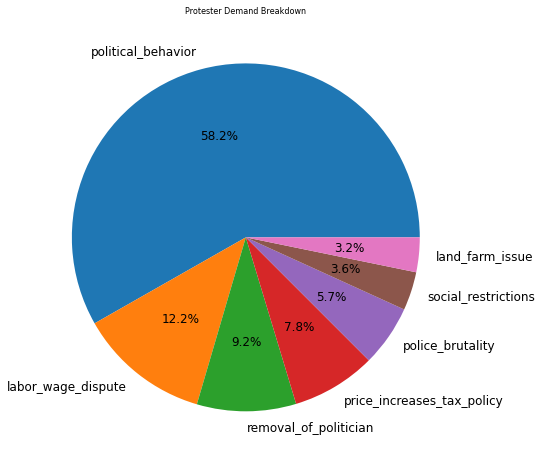

In [23]:
#Creating pie chart of the distribution of protester demands
dem_pct.dem_pct.plot(kind='pie', labels= dem_pct['dem_feature'],figsize=(12,8),fontsize=12,autopct='%1.1f%%' )
plt.title('Protester Demand Breakdown')
plt.ylabel(' ')
plt.style.use('default')
#plt.savefig('1_Demand_pct_Breakdown.png')
plt.show()

Creating 'Violence Response' column. For the purpose of this project, killings, shootings and beatings are being considered violent state responses. 

In [22]:
df2['Violent_Response']= (df2['killings']+df2['shootings']+df2['beatings'])>0

In [24]:
df2['Violent_Response'].head(3)

0    False
1    False
2    False
Name: Violent_Response, dtype: bool

Next, I created a graph of mean violent response per demand to get an idea of how often, on average, there was a violent response for each demand. 

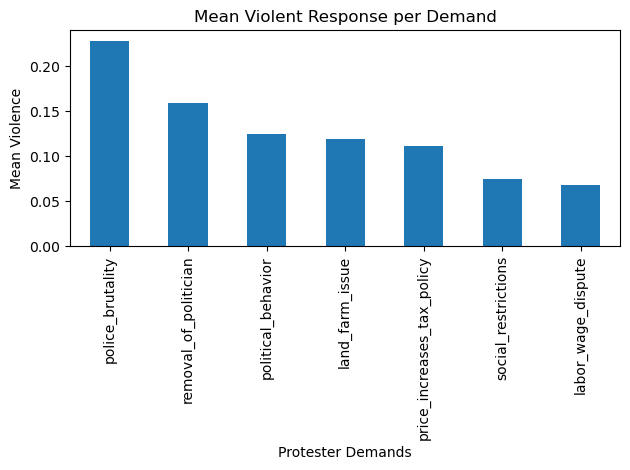

In [25]:
#Creating graph of mean violent response per demand
dic = {}
for demand in dem_columns:
    dic[demand] = df2[df2[demand] == 1]['Violent_Response'].mean()
    
#pd.DataFrame([dic]).T.sort_values(by=0, ascending=False).plot(kind='bar')
pd.DataFrame.from_dict(dic, orient = "index", columns = ['Violent_Response']).sort_values(by='Violent_Response', ascending=False).plot(kind='bar')
plt.legend().remove()
plt.title('Mean Violent Response per Demand')
plt.xlabel('Protester Demands')
plt.ylabel('Mean Violence')
plt.style.use('default')
plt.tight_layout()
#plt.savefig('2_Avg_Violence_per_Demand.png')

The protest demands did not incite a state violence response at an equal rate. Thus a chi squared test for each demand was tested to verify whether the observed difference in each demand is statistically significant compared to the mean. 

In [26]:
#Creating contingency for police_brutality chi squared test(1/7)
police_brut_contingency_table = pd.crosstab(df2["police_brutality"],
                            df2['Violent_Response'], 
                               margins = False)
print(police_brut_contingency_table)

#Chi-squared test to verify whether the observed difference in police_brutality is statistically significant
stat, p, dof, expected = chi2_contingency(police_brut_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
police_brutality              
False             11918   1567
True                769    228
probability=0.950, critical=3.841, stat=107.141
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [27]:
#Creating contingency for removal_of_politician chi squared test(2/7)
removal_contingency_table = pd.crosstab(df2["removal_of_politician"],
                            df2['Violent_Response'], 
                               margins = False)
print(removal_contingency_table)

#Chi-squared test to verify whether the observed difference in removal_of_politician is statistically significant
stat, p, dof, expected = chi2_contingency(removal_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response       False  True 
removal_of_politician              
False                  11333   1539
True                    1354    256
probability=0.950, critical=3.841, stat=20.143
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [28]:
#Creating contingency for political_behavior chi squared test(3/7)
pol_behavior_contingency_table = pd.crosstab(df2["political_behavior"],
                            df2['Violent_Response'], 
                               margins = False)
print(pol_behavior_contingency_table)

#Chi-squared test to verify whether the observed difference in political_behavior is statistically significant
stat, p, dof, expected = chi2_contingency(pol_behavior_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response    False  True 
political_behavior              
False                3777    526
True                 8910   1269
probability=0.950, critical=3.841, stat=0.143
Independent (fail to reject H0)
significance=0.050, p=0.706
Independent (fail to reject H0)


In [29]:
#Creating contingency for land_farm_issue chi squared test(4/7)
land_contingency_table = pd.crosstab(df2["land_farm_issue"],
                            df2['Violent_Response'], 
                               margins = False)
print(land_contingency_table)

#Chi-squared test to verify whether the observed difference in land_farm_issue is statistically significant
stat, p, dof, expected = chi2_contingency(land_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
land_farm_issue               
False             12192   1728
True                495     67
probability=0.950, critical=3.841, stat=0.079
Independent (fail to reject H0)
significance=0.050, p=0.778
Independent (fail to reject H0)


In [30]:
#Creating contingency for price_increases_tax_policy chi squared test(5/7)
tax_contingency_table = pd.crosstab(df2["price_increases_tax_policy"],
                            df2['Violent_Response'], 
                               margins = False)
print(tax_contingency_table)

#Chi-squared test to verify whether the observed difference in price_increases_tax_policy is statistically significant
stat, p, dof, expected = chi2_contingency(tax_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response            False  True 
price_increases_tax_policy              
False                       11471   1642
True                         1216    153
probability=0.950, critical=3.841, stat=1.946
Independent (fail to reject H0)
significance=0.050, p=0.163
Independent (fail to reject H0)


In [31]:
#Creating contingency for social_restrictions chi squared test(6/7)
social_contingency_table = pd.crosstab(df2["social_restrictions"],
                            df2['Violent_Response'], 
                               margins = False)
print(social_contingency_table)

#Chi-squared test to verify whether the observed difference in social_restrictions is statistically significant
stat, p, dof, expected = chi2_contingency(social_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response     False  True 
social_restrictions              
False                12108   1748
True                   579     47
probability=0.950, critical=3.841, stat=13.923
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [32]:
#Creating contingency for labor_wage_dispute chi squared test(7/7)
wage_contingency_table = pd.crosstab(df2["labor_wage_dispute"],
                            df2['Violent_Response'], 
                               margins = False)
print(wage_contingency_table)

#Chi-squared test to verify whether the observed difference in labor_wage_dispute is statistically significant
stat, p, dof, expected = chi2_contingency(wage_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response    False  True 
labor_wage_dispute              
False               10696   1649
True                 1991    146
probability=0.950, critical=3.841, stat=70.841
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In summary, the following demands displayed statistical significance compared to the mean:
* police_brutality
* removal_of_politician
* social_restrictions
* labor_wage_dispute

## Responses Breakdown  <a class="anchor" id="demands"></a>

Creating a dataframe that specifies the percentage of each state response in the dataset in order to see the breakdown of responses.

In [33]:
#Counting the total number of responses
resp_total = df.responses_count.sum()

In [34]:
resp_total = df.demands_count.sum()
resp_columns = ["accomodation","arrests","beatings","crowd_dispersal","ignore","killings","shootings"]
resp_feature = []
resp_pct_col = []

for col in resp_columns:
    resp_feature.append(col)
    resp_pct_col.append(round((df[col].sum()/resp_total)*100,2))
    print (col)

accomodation
arrests
beatings
crowd_dispersal
ignore
killings
shootings


In [35]:
#collating the state response with it's frequency
resp_feat_pct = zip(resp_feature,resp_pct_col)

In [36]:
#creating dataframe of responses and percentages, sorted by frequency (high to low)
resp_pct = pd.DataFrame(resp_feat_pct, columns=['resp_feature','resp_pct']).sort_values(by='resp_pct',ascending=False)

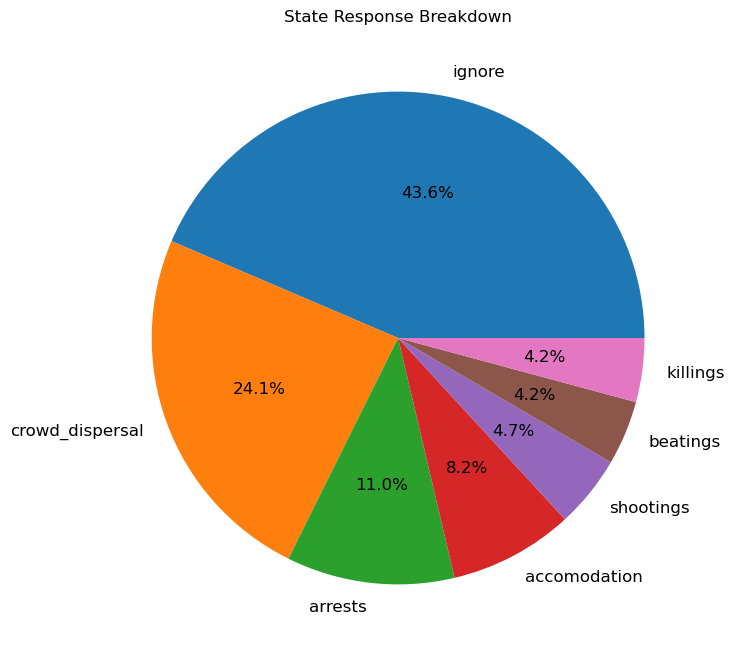

In [37]:
#Creating pie chart of the distribution of state responses
resp_pct.resp_pct.plot(kind='pie', labels= resp_pct['resp_feature'] ,figsize=(12,8),fontsize=12,autopct='%1.1f%%' )
plt.title('State Response Breakdown')
plt.ylabel(' ')
plt.style.use('default')
#plt.savefig('5_Response_pct_Breakdown.png')
plt.show()

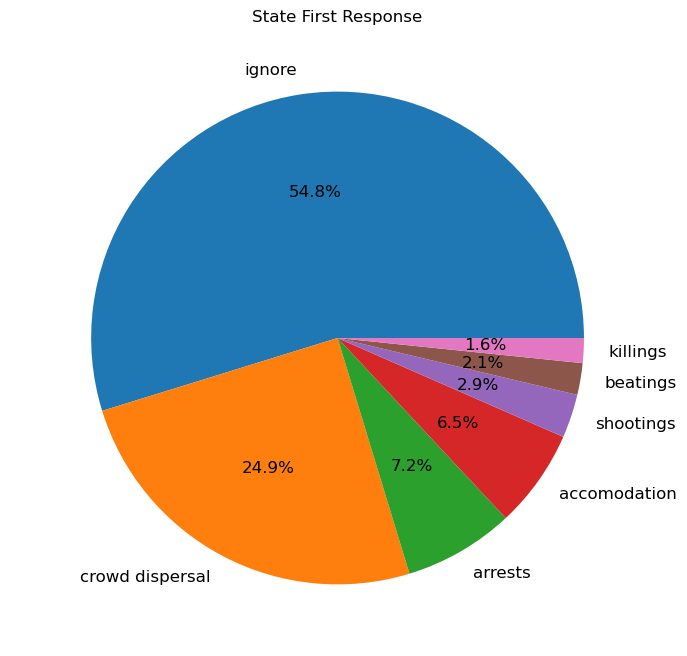

In [38]:
df.first_response.value_counts().plot(kind='pie',figsize=(12,8),fontsize=12,autopct='%1.1f%%' )
plt.title('State First Response')
plt.ylabel(' ')
plt.style.use('default')
plt.show()

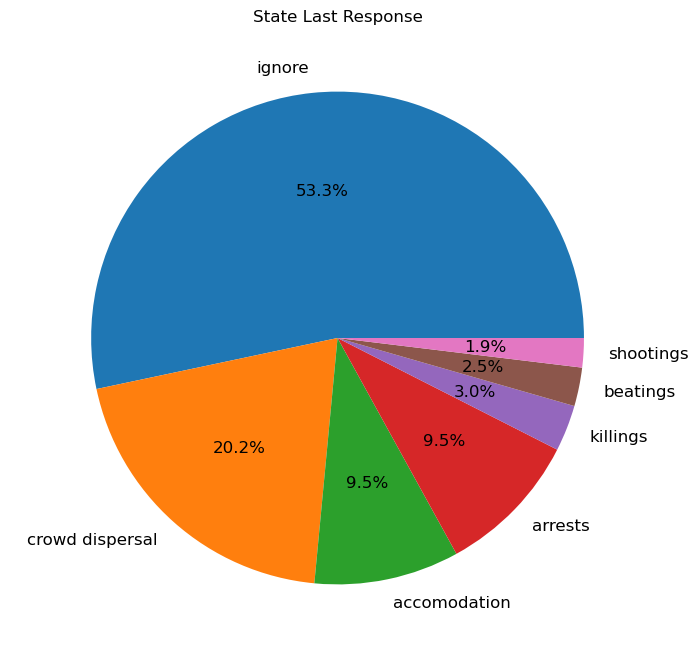

In [39]:
df.last_response.value_counts().plot(kind='pie',figsize=(12,8),fontsize=12,autopct='%1.1f%%' )
plt.title('State Last Response')
plt.ylabel(' ')
plt.style.use('default')
plt.show()

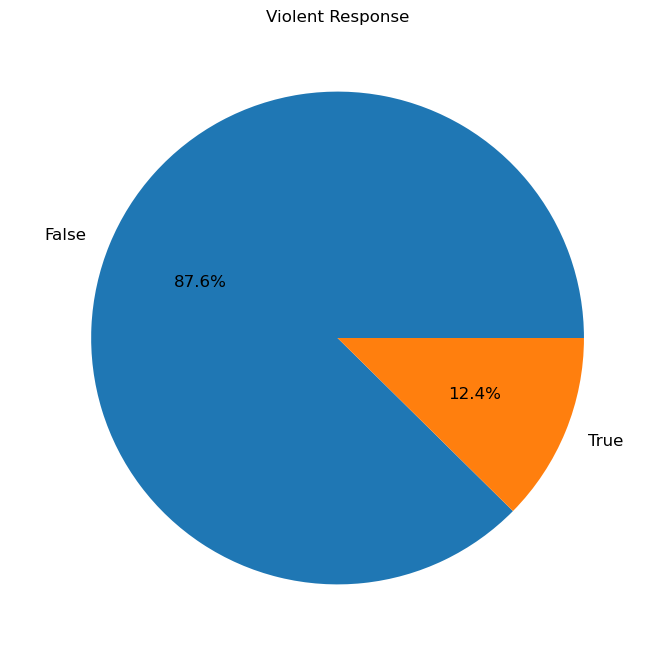

In [44]:
df2.Violent_Response.value_counts().plot(kind='pie',figsize=(12,8),fontsize=12,autopct='%1.1f%%' )
plt.title('Violent Response')
plt.ylabel(' ')
plt.style.use('default')
plt.show()

## Breakdown of Violence by Country  <a class="anchor" id="country"></a>

In [45]:
#Violent response by country without filtering by count - head
df2[['country', 'Violent_Response']].groupby('country').agg(['mean','count']).sort_values(by=[('Violent_Response','mean')], ascending= False).head(10)

Violent_Response      
                                  mean count
country                                     
South Sudan                   1.000000     1
Djibouti                      0.700000    10
Guinea                        0.539326    89
Serbia and Montenegro         0.500000     2
Bhutan                        0.500000     2
Ethiopia                      0.486486    37
Uganda                        0.482759    58
Chad                          0.411765    17
Panama                        0.408163    49
Sudan                         0.403846    52

In [46]:
#Violent response by country without filtering by count - tail
df2[['country', 'Violent_Response']].groupby('country').agg(['mean','count']).sort_values(by=[('Violent_Response','mean')], ascending= False).tail(10)

Violent_Response      
                        mean count
country                           
Ireland                  0.0   428
Japan                    0.0    57
Switzerland              0.0     5
Sweden                   0.0    16
Suriname                 0.0    51
Cape Verde               0.0     2
Qatar                    0.0     1
Cyprus                   0.0   125
Singapore                0.0    14
Kosovo                   0.0    19

In [47]:
#Converting violence mean/count by country into data frame
country_violence = pd.DataFrame(df2[['country', 'Violent_Response']].groupby('country').agg(['mean','count']))

In [48]:
#creating mask for countries with a count of more than 20 observations
ok_country = country_violence[("Violent_Response", "count")] > 20

In [49]:
#Violence response with >20 filter - head
country_violence[ok_country].sort_values(by=[('Violent_Response','mean')], ascending= False).head(10)

Violent_Response      
                                     mean count
country                                        
Guinea                           0.539326    89
Ethiopia                         0.486486    37
Uganda                           0.482759    58
Panama                           0.408163    49
Sudan                            0.403846    52
Congo Kinshasa                   0.397260    73
Yemen                            0.375796   157
Egypt                            0.360656   122
Central African Republic         0.360656    61
Iran                             0.339130   115

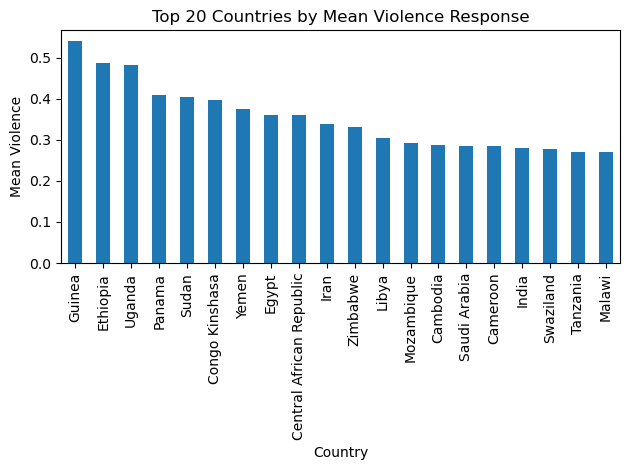

In [50]:
#Graphing top 20 most violent countries (on average)
country_violence[ok_country][('Violent_Response','mean')].sort_values(ascending= False).nlargest(n=20).plot(kind='bar')
plt.title('Top 20 Countries by Mean Violence Response')
plt.xlabel('Country')
plt.ylabel('Mean Violence')
plt.style.use('default')
plt.tight_layout()
#plt.savefig('3_Avg_Violence_per_Country.png')

In [51]:
#Violence response with >20 filter - tail
country_violence[ok_country].sort_values(by=[('Violent_Response','mean')], ascending= False).tail(10)

Violent_Response      
                           mean count
country                              
Belgium                     0.0    41
Uruguay                     0.0    68
Lithuania                   0.0    35
Cyprus                      0.0   125
France                      0.0   526
Ireland                     0.0   428
Mongolia                    0.0    49
Estonia                     0.0    48
Slovenia                    0.0    21
Czech Republic              0.0    23

In [52]:
#Creating contingency for country chi squared test
country_contingency_table = pd.crosstab(df2['country'],
                            df2['Violent_Response'], 
                               margins = False)
print(country_contingency_table)

#Chi-squared test to verify whether the observed difference in every country is statistically significant
stat, p, dof, expected = chi2_contingency(country_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
country                       
Afghanistan          33      5
Albania              52     15
Algeria              48     10
Angola               17      6
Argentina           106      5
...                 ...    ...
Vietnam              17      2
Yemen                98     59
Yugoslavia          110     27
Zambia               80     14
Zimbabwe             73     36

[166 rows x 2 columns]
probability=0.950, critical=195.973, stat=1766.136
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Country is a statistically significant feature.

## Breakdown of Violence by Region <a class="anchor" id="region"></a>

In [53]:
#Violent response by region
region_violence = pd.DataFrame(df2[['region', 'Violent_Response']].groupby('region').agg(['mean','count']))

In [54]:
#Violent response by region, sorted high to low 
region_violence.sort_values(by=[('Violent_Response','mean')], ascending= False)

Violent_Response      
                            mean count
region                                
MENA                    0.247027  1093
Africa                  0.205795  3037
Asia                    0.153510  2977
Central America         0.149770   434
North America           0.110000   500
South America           0.080251  1595
Oceania                 0.078947    38
Europe                  0.039933  4808

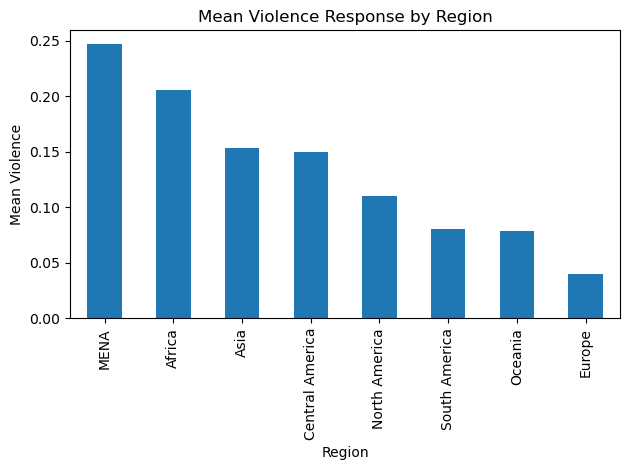

In [55]:
#Graphing mean violence in region from most to least violent region
region_violence[('Violent_Response','mean')].sort_values(ascending= False).plot(kind='bar')
plt.title('Mean Violence Response by Region')
plt.xlabel('Region')
plt.ylabel('Mean Violence')
plt.style.use('default')
plt.tight_layout()
#plt.savefig('4_Avg_Violence_per_region.png')

In [56]:
#Creating contingency for violence in region chi squared test
region_contingency_table = pd.crosstab(df2['region'],
                            df2['Violent_Response'], 
                               margins = False)
print(region_contingency_table)

stat, p, dof, expected = chi2_contingency(region_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
region                        
Africa             2412    625
Asia               2520    457
Central America     369     65
Europe             4616    192
MENA                823    270
North America       445     55
Oceania              35      3
South America      1467    128
probability=0.950, critical=14.067, stat=708.665
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


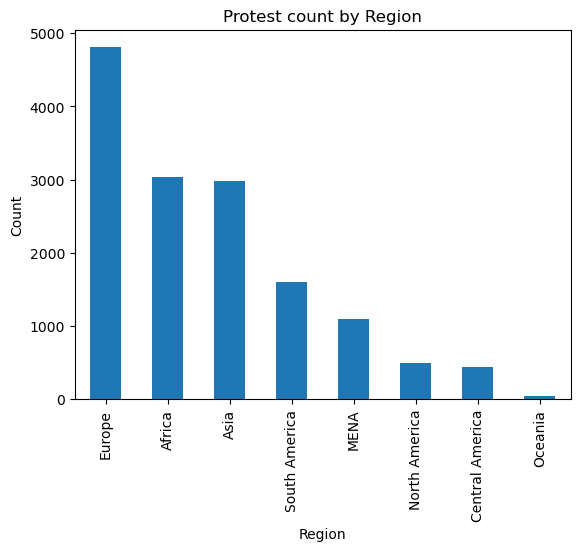

In [36]:
#Graphing protest count by region, sorted high to low
region_violence[('Violent_Response','count')].sort_values(ascending= False).plot(kind='bar')
plt.title('Protest count by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.style.use('default')
plt.savefig('count_per_region.png')

Region is a statistically significant feature.

## Violence by Year <a class="anchor" id="year"></a>

In [57]:
#Violent response by year
year_violence = pd.DataFrame(df2[['year', 'Violent_Response']].groupby('year').agg(['mean','count']))

In [59]:
#Violent response by year, sorted high to low  
year_violence.sort_values(by=[('Violent_Response','mean')], ascending= False).head()

Violent_Response      
                 mean count
year                       
1990         0.219684   569
1991         0.199461   371
2011         0.192982   684
1993         0.176829   328
1992         0.173594   409

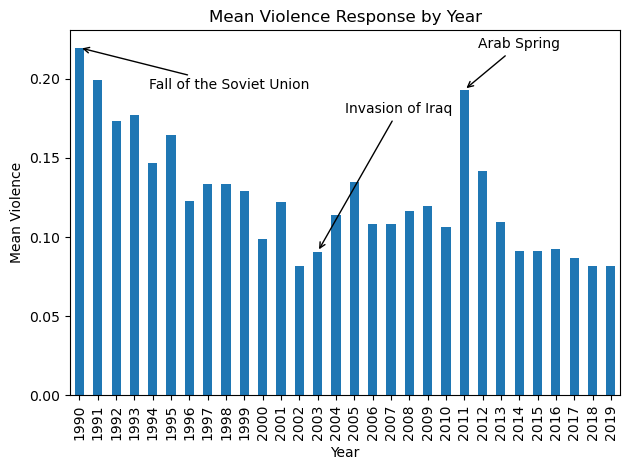

In [60]:
#Graphing mean violence by year in chronological order
year_violence[('Violent_Response','mean')].plot(kind='bar')
plt.title('Mean Violence Response by Year')
plt.xlabel('Year')
plt.ylabel('Mean Violence')

plt.annotate("Fall of the Soviet Union", xy=(0, 0.219684),
            xytext=(50, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0"))
plt.annotate("Arab Spring", xy=(21, 0.192982),
            xytext=(10, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0."))
plt.annotate("Invasion of Iraq", xy=(13, 0.090674),
            xytext=(20, 100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))
plt.style.use('default')
plt.tight_layout()
#plt.savefig('6_Avg_Violence_per_year.png')

In [61]:
#Creating contingency for violence by year chi squared test
year_contingency_table = pd.crosstab(df2['year'],
                            df2['Violent_Response'], 
                               margins = False)
print(year_contingency_table)
#Chi-squared test to verify whether the observed violence each year is statistically significant
stat, p, dof, expected = chi2_contingency(year_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
year                          
1990                444    125
1991                297     74
1992                338     71
1993                270     58
1994                332     57
1995                295     58
1996                358     50
1997                422     65
1998                383     59
1999                357     53
2000                439     48
2001                344     48
2002                381     34
2003                351     35
2004                388     50
2005                430     67
2006                405     49
2007                396     48
2008                350     46
2009                331     45
2010                404     48
2011                552    132
2012                473     78
2013                520     64
2014                699     70
2015                779     78
2016                647     66
2017                493     47
2018                641     57
2019                168     15
probabil

Year is a statistically significant feature.

## Seasonal Distribution <a class="anchor" id="season"></a>

In order to gauge how the time of year influenced state violence, I first looked at the start month to see how violence was distributed across the year. Since the weather is dependent on the hemisphere and the time of year, I assigned southern or northern hemisphere to each country. After this, I created a new column to hold the season by using the month and the hemisphere.  

Text(0, 0.5, 'Number of Protests')

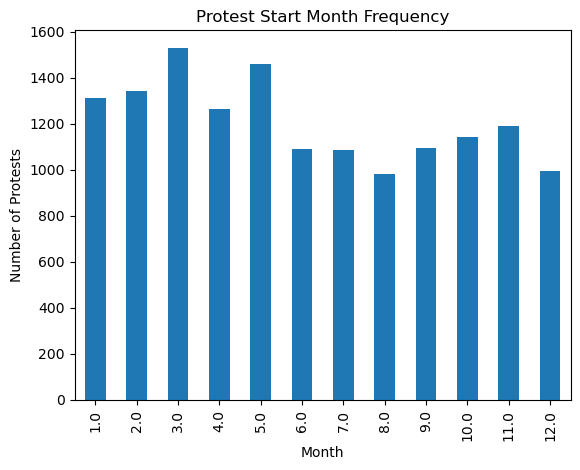

In [62]:
#Graphing the number of protests by month
start_month = df.groupby("startmonth").protest.count().plot(kind='bar', title='Protest Start Month Frequency')
start_month.set_xlabel("Month")
start_month.set_ylabel("Number of Protests")

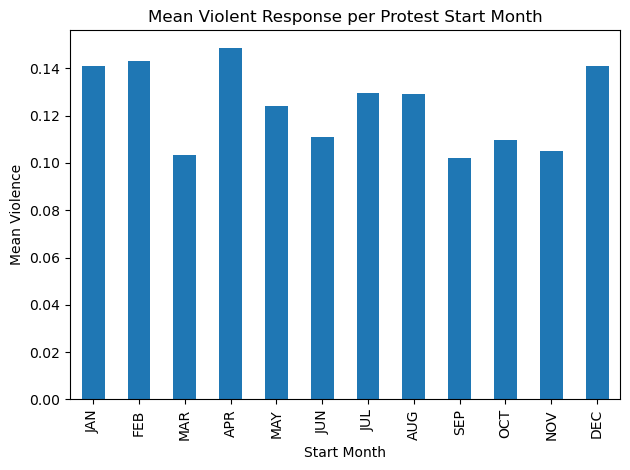

In [63]:
#Graphing mean violence per month in chronological order
viol_mon = df2[['startmonth','Violent_Response']].groupby("startmonth").mean().plot(kind='bar',title='Mean Violent Response per Protest Start Month', xlabel='Start Month', ylabel='Mean Violence')
viol_mon.legend().remove()
x_labels = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
viol_mon.set_xticklabels(x_labels)
plt.tight_layout()
plt.style.use('default')
#plt.savefig('8_Violence_Across_Startmonth.png')

In [64]:
#Creating contingency for violence by start month chi squared test
start_contingency_table = pd.crosstab(df2['startmonth'],
                            df2['Violent_Response'], 
                               margins = False)
print(start_contingency_table)
#Chi-squared test to verify whether the observed violence each start month is statistically significant
stat, p, dof, expected = chi2_contingency(start_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
startmonth                    
1.0                1126    185
2.0                1149    192
3.0                1372    158
4.0                1077    188
5.0                1277    181
6.0                 968    121
7.0                 946    141
8.0                 855    127
9.0                 984    112
10.0               1015    125
11.0               1064    125
12.0                854    140
probability=0.950, critical=19.675, stat=36.903
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Start month is a statistically significant feature.

Preparing data to look into what season the demonstration happened in, to assess if they are related to a violent state response.

In [65]:
#Creating list of souther hemisphere countries
#The cut off for this list was country "mostly in souther hemisphere"
southern_hem_countries = ['Australia', 'Papua New Guinea', 'Argentina', 'Bolivia', 'Chile', 'Paraguay', 'Peru', 'Uruguay', 'Brazil', 'Ecuador','Angola', 'Botswana','Burundi','Comoros','Eswatini','Lesotho','Madagascar','Malawi','Mauritius','Mayotte','Mozambique','Namibia','Reunion','Rwanda','Seychelles','South Africa','Tanzania','Zambia','Zimbabwe','The Democratic Republic of the Congo','Gabon','East Timor','Indonesia']

In [66]:
#Creating hemisphere column
df2['hemisphere'] = ['southern' if country in southern_hem_countries else 'northern' for country in df2['country']]

In [69]:
df2[['hemisphere','Violent_Response']].groupby("hemisphere").agg(['mean','count'])

Violent_Response       
                       mean  count
hemisphere                        
northern           0.123744  12041
southern           0.124949   2441

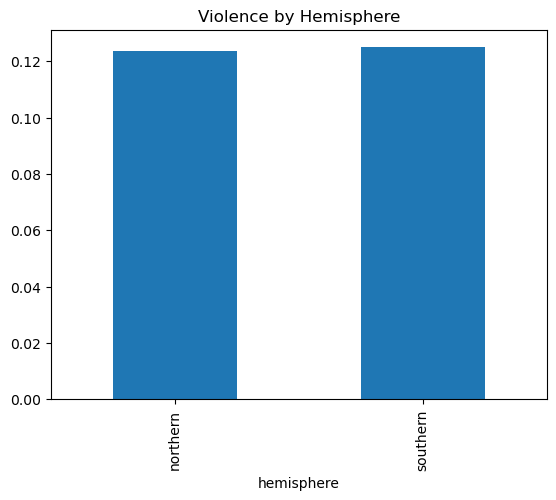

In [67]:
#Plotting violence by hemisphere
hem_viol = df2[['hemisphere','Violent_Response']].groupby("hemisphere").mean().plot(kind='bar', title='Violence by Hemisphere')
hem_viol.legend().remove()

In [68]:
#Creating contingency for violence by hemisphere chi squared test
hemi_contingency_table = pd.crosstab(df2['hemisphere'],
                            df2['Violent_Response'], 
                               margins = False)
print(hemi_contingency_table)

stat, p, dof, expected = chi2_contingency(hemi_contingency_table)
#print('dof=%d' % dof)
#print(expected)

#interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
#interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
hemisphere                    
northern          10551   1490
southern           2136    305
probability=0.950, critical=3.841, stat=0.017
Independent (fail to reject H0)
significance=0.050, p=0.896
Independent (fail to reject H0)


Hemisphere is not a statistically significant feature.

In [70]:
#creating list of season conditions
conditions_sea = [
    ((df2['hemisphere'] == 'northern') & (df2['startmonth'].isin([12,1,2]))),
    ((df2['hemisphere'] == 'northern') & (df2['startmonth'].isin([3,4,5]))),
    ((df2['hemisphere'] == 'northern') & (df2['startmonth'].isin([6,7,8]))),
    ((df2['hemisphere'] == 'northern') & (df2['startmonth'].isin([9,10,11]))),
    ((df2['hemisphere'] == 'southern') & (df2['startmonth'].isin([6,7,8]))),
    ((df2['hemisphere'] == 'southern') & (df2['startmonth'].isin([9,10,11]))),
    ((df2['hemisphere'] == 'southern') & (df2['startmonth'].isin([12,1,2]))),
    ((df2['hemisphere'] == 'southern') & (df2['startmonth'].isin([3,4,5])))
    ]

#creating list of the values to assign to each condition
values_sea = ['winter', 'spring', 'summer', 'autumn','winter','spring','summer','autumn']

#creating a new column using np.select to assign values using condition list as argument
df2['season'] = np.select(conditions_sea, values_sea)



In [71]:
df2[['season','Violent_Response']].groupby("season").agg(['mean','count']).sort_index()#sort_values(by=[('Violent_Response','mean')], ascending= False)

Violent_Response      
                   mean count
season                       
autumn         0.105949  3681
spring         0.124844  3997
summer         0.134126  3027
winter         0.132380  3777

In [72]:
seasons_ = ['spring', 'summer', 'autumn','winter']
mapping = {season: i for i, season in enumerate(seasons_)}
key = df2['season'].map(mapping)

In [73]:
#sorting seasons
sorted_season = df2.iloc[key.argsort()]

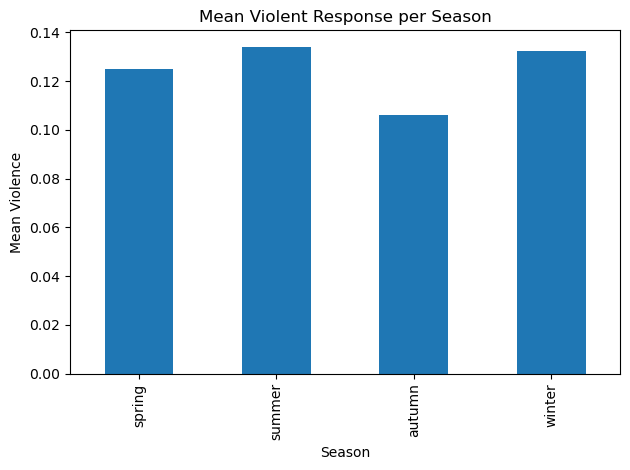

In [74]:
#Graphing mean violence by season from spring to winter
viol_season = sorted_season[['season','Violent_Response']].groupby(key).mean().plot(kind='bar',title='Mean Violent Response per Season', xlabel='Season', ylabel='Mean Violence')
x_labels = seasons_
viol_season.set_xticklabels(x_labels)
viol_season.legend().remove()
plt.style.use('default')
plt.tight_layout()
#plt.savefig('7a_Violence_Across_Seasons.png')

In [75]:
#Creating contingency for violence in region chi squared test
season_contingency_table = pd.crosstab(df2['season'],
                            df2['Violent_Response'], 
                               margins = False)
print(season_contingency_table)

#chi-squared test to verify whether the observed violence each season is statistically significant
stat, p, dof, expected = chi2_contingency(season_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
season                        
autumn             3291    390
spring             3498    499
summer             2621    406
winter             3277    500
probability=0.950, critical=7.815, stat=16.372
Dependent (reject H0)
significance=0.050, p=0.001
Dependent (reject H0)


In summary, hemisphere was not statistically significant. Season and start month, on the other hand showed to be statistically significant.

## Protest duration <a class="anchor" id="duration"></a>

In [76]:
#Calculating protest duration
duration = df2.end_date - df2.start_date

In [77]:
#Creating duration column
df2['dur_column'] = duration.dt.days + 1

Text(0, 0.5, 'Number of Protests')

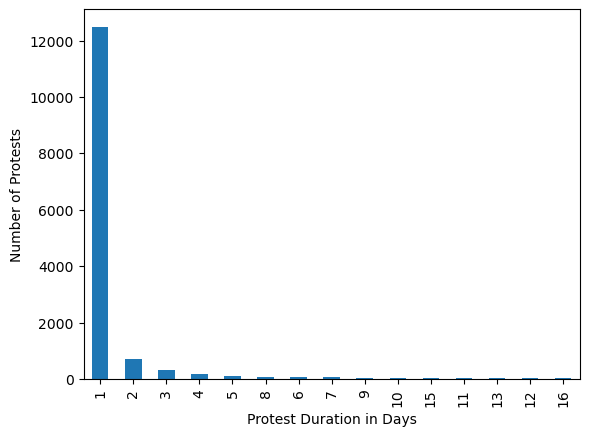

In [78]:
#Graphing the frequency of protest duration 
protest_duration = df2.groupby("dur_column").first_response.count().nlargest(n=15).plot(kind= "bar")
protest_duration.set_xlabel("Protest Duration in Days")
protest_duration.set_ylabel("Number of Protests")

In [79]:
#creating a simplified version of the duration column, where anything over a week is 7+
df2['dur_column2'] = df2['dur_column'].apply(lambda x: str(x) if x < 8 else '7+')

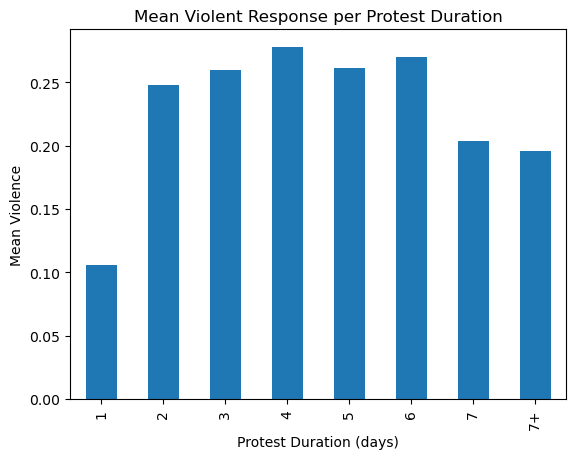

In [80]:
#Graphing mean violence by protest duration
viol_dur = df2[['dur_column2','Violent_Response']].groupby("dur_column2").mean().sort_values(by = "dur_column2", ascending= True).plot(kind='bar',title='Mean Violent Response per Protest Duration', xlabel='Protest Duration (days)', ylabel='Mean Violence')
viol_dur.legend().remove()
plt.style.use('default')
#plt.savefig('9_Violence_Across_Duration.png')

In [81]:
#Creating contingency for violence by duration chi squared test
dur_contingency_table = pd.crosstab(df2['dur_column2'],
                            df2['Violent_Response'], 
                               margins = False)
print(dur_contingency_table)

#chi-squared test to verify whether the observed violence at each duration is statistically significant
stat, p, dof, expected = chi2_contingency(dur_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
dur_column2                   
1                 11160   1321
2                   538    177
3                   225     79
4                   117     45
5                    82     29
6                    46     17
7                    43     11
7+                  476    116
probability=0.950, critical=14.067, stat=288.364
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Protest duration is statistically significant.

## Participant Category Breakdown <a class="anchor" id="part_category"></a>

The number of participants were binned in 7 participant categories.

Text(0, 0.5, 'Number of Protests')

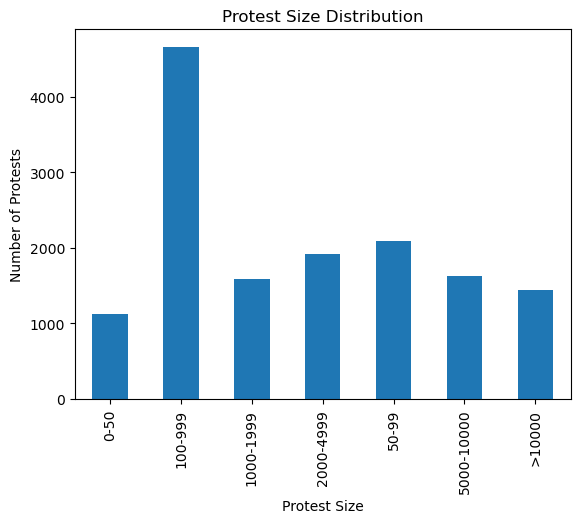

In [82]:
#Plotting Protest size frequency distribution
protest_size = df.groupby("new_participants_category").protest.count().plot(kind='bar', title='Protest Size Distribution')
protest_size.set_xlabel("Protest Size")
protest_size.set_ylabel("Number of Protests")


In [83]:
df2[['new_participants_category','Violent_Response']].groupby("new_participants_category").agg(['mean','count'])

Violent_Response      
                                      mean count
new_participants_category                       
0-50                              0.114362  1128
100-999                           0.135437  4659
1000-1999                         0.160277  1591
2000-4999                         0.113365  1923
50-99                             0.117169  2091
5000-10000                        0.118154  1625
>10000                            0.084254  1448

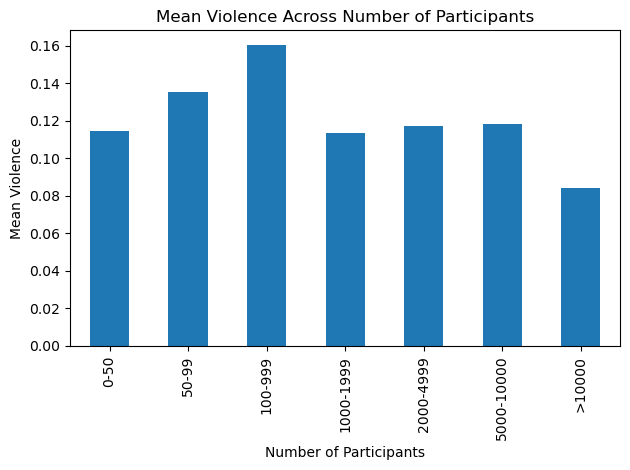

In [84]:
#Graphing mean violence by participant category
viol_part_cat = df2[['new_participants_category','Violent_Response']].groupby("new_participants_category").mean().plot(kind='bar',xlabel= 'Number of Participants', ylabel = 'Mean Violence', title= 'Mean Violence Across Number of Participants')
viol_part_cat.legend().remove()
ticks = [0,1,2,3,4,5,6]
labels = ['0-50','50-99','100-999','1000-1999', '2000-4999','5000-10000','>10000']
viol_part_cat.set_xticks(ticks)
viol_part_cat.set_xticklabels(labels)
plt.tight_layout()
plt.style.use('default')
#plt.savefig('10_Violence_Across_participant_cat.png')


In [85]:
#Creating contingency for violence by participant category chi squared test
part_contingency_table = pd.crosstab(df2['new_participants_category'],
                            df2['Violent_Response'], 
                               margins = False)
print(part_contingency_table)
#chi-squared test to verify whether the observed violence at each duration is statistically significant
stat, p, dof, expected = chi2_contingency(part_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response           False  True 
new_participants_category              
0-50                         999    129
100-999                     4028    631
1000-1999                   1336    255
2000-4999                   1705    218
50-99                       1846    245
5000-10000                  1433    192
>10000                      1326    122
probability=0.950, critical=12.592, stat=50.359
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Participants Category is statistically significant.

## More than one demand Breakdown <a class="anchor" id="multidemands"></a>

Looking into the instances in which protesters had multiple demands and whether these incited more violence from the state or not. 

In [86]:
multi_demand = pd.DataFrame(df2[['demands_count', 'Violent_Response']].groupby('demands_count').agg(['mean','count']))

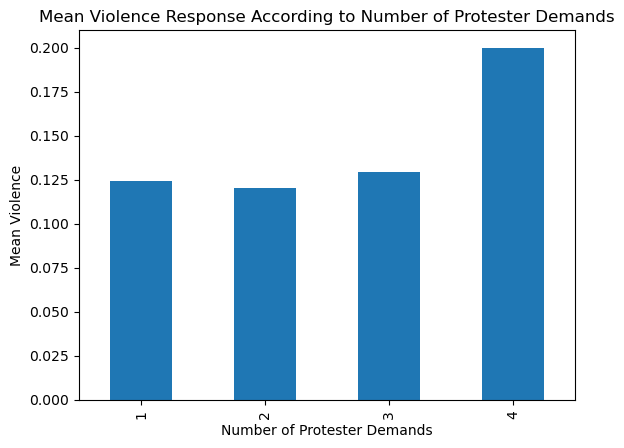

In [87]:
#Graphing mean violence by number of demands
multi_demand[('Violent_Response','mean')].plot(kind='bar')
plt.title('Mean Violence Response According to Number of Protester Demands')
plt.xlabel('Number of Protester Demands')
plt.ylabel('Mean Violence')
plt.style.use('default')
#plt.savefig('11_Avg_Violence_multidemand.png')

In [88]:
#Creating contingency for violence by number of demands chi squared test
multidemand_contingency_table = pd.crosstab(df2['demands_count'],
                            df2['Violent_Response'], 
                               margins = False)
print(multidemand_contingency_table)
#chi-squared test to verify whether the observed violence at each duration is statistically significant
stat, p, dof, expected = chi2_contingency(multidemand_contingency_table)
#print('dof=%d' % dof)
#print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
demands_count                 
1                 10348   1470
2                  2067    283
3                   256     38
4                    16      4
probability=0.950, critical=7.815, stat=1.431
Independent (fail to reject H0)
significance=0.050, p=0.698
Independent (fail to reject H0)


Having more than one demand is not statistically significant.

## More than one response Breakdown <a class="anchor" id="multiresponse"></a>

Looking into the instances in which the state responded more than one and whether more responses are consistent with more violence. 

In [89]:
multi_response = pd.DataFrame(df2[['responses_count', 'Violent_Response']].groupby('responses_count').agg(['mean','count']))

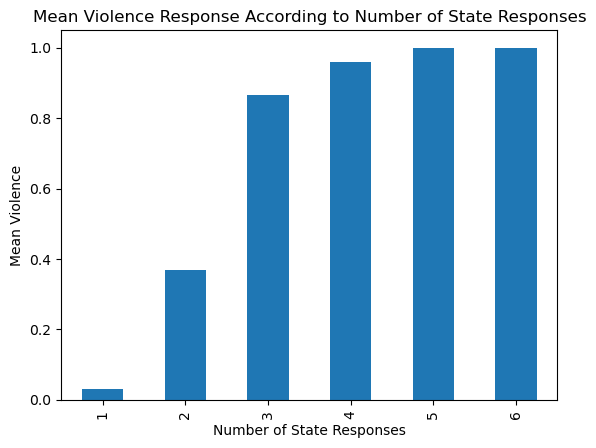

In [90]:
#Graphing mean violence by number of state responses
multi_response[('Violent_Response','mean')].sort_values(ascending= True).plot(kind='bar')
plt.title('Mean Violence Response According to Number of State Responses')
plt.xlabel('Number of State Responses')
plt.ylabel('Mean Violence')
plt.style.use('default')
#plt.savefig('12_Avg_Violence_multiresponse.png')

In [91]:
#Creating contingency for violence by number of responses chi squared test
multiresponse_contingency_table = pd.crosstab(df2['responses_count'],
                            df2['Violent_Response'], 
                               margins = False)
print(multiresponse_contingency_table)
#Chi-squared test to verify whether the observed violence at each duration is statistically significant
stat, p, dof, expected = chi2_contingency(multiresponse_contingency_table)
#print('dof=%d' % dof)
#print(expected)

#interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
#interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response  False  True 
responses_count               
1                 11413    354
2                  1183    694
3                    84    538
4                     7    167
5                     0     34
6                     0      8
probability=0.950, critical=11.070, stat=6560.715
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Number of state responses is statistically significant. 


## Protestor Violence Breakdown <a class="anchor" id="prot_violence"></a>

Exploring how protester violence relates to violent state responses.

In [92]:
prot_violence = pd.DataFrame(df2[['protesterviolence', 'Violent_Response']].groupby('protesterviolence').agg(['mean','count']))

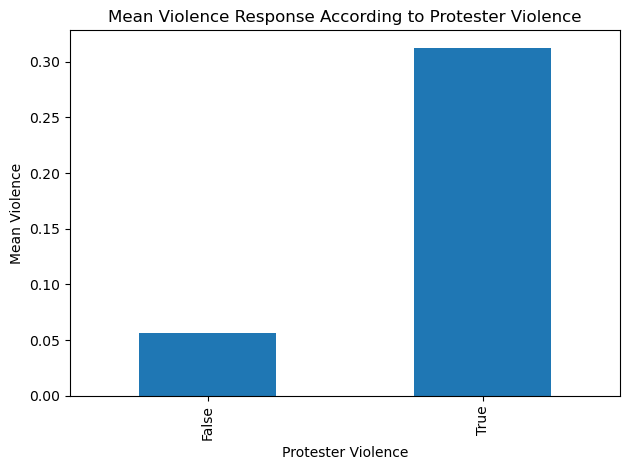

In [93]:
#Graphing mean violence given protester violence
prot_violence[('Violent_Response','mean')].sort_values(ascending= True).plot(kind='bar')
plt.title('Mean Violence Response According to Protester Violence')
plt.xlabel('Protester Violence')
plt.ylabel('Mean Violence')
plt.tight_layout()
plt.style.use('default')
#plt.savefig('13_Avg_Violence_prot_violence.png')

In [94]:
#Creating contingency for violence by protester violence chi squared test
Prot_viol_contingency_table = pd.crosstab(df2['protesterviolence'],
                            df2['Violent_Response'], 
                               margins = False)
print(Prot_viol_contingency_table)
#Chi-squared test to verify whether the observed violence with protester violence is statistically significant
stat, p, dof, expected = chi2_contingency(Prot_viol_contingency_table)
#print('dof=%d' % dof)
#print(expected)

#interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
#interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Violent_Response   False  True 
protesterviolence              
False              10069    605
True                2618   1190
probability=0.950, critical=3.841, stat=1689.250
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Protester violence is statistically significant.

#### Stacked graph for State response <a class="anchor" id="stack"></a>

In [96]:
#Number of state response
r = [0,1,2,3,4,5,6]
#list of columns for each iterative state response
responsecols = ['stateresponse1_y', 'stateresponse2_y', 'stateresponse3_y', 'stateresponse4_y',
       'stateresponse5_y', 'stateresponse6_y', 'stateresponse7_y']
#creating dictionary of response count per each state response column
sr_list = [df[responsenum].value_counts().to_dict() for responsenum in responsecols]

In [97]:
#Creating list of unique responses
unique_responses = sr_list[0].keys()
#Initializing totals dictionary
totals = {}
#Adding up each response type and adding it to dictionary totals
for response in unique_responses:
    totals[response] = 0

    for dic in sr_list:
        if response in dic:

            totals[response] += dic[response]

In [98]:
#Creating list of response distribution per noted response(iteration)
response_bars = []
response_bars_dict = []
response_types = sr_list[0].keys()

for response in sr_list:
    newlist = []
    newdict = {}
    for response_type in response_types:
        if response_type in response:
            newlist.append(response[response_type]/np.sum(list(response.values())))
            newdict[response_type] = response[response_type]/np.sum(list(response.values()))
        else:
            newlist.append(0)
            newdict[response_type] = 0
    response_bars.append(newlist)
    response_bars_dict.append(newdict)
print(response_bars)

[[0.5478591160220995, 0.24930939226519336, 0.07244475138121546, 0.06470994475138121, 0.028660220994475138, 0.020718232044198894, 0.016298342541436465], [0.012159174649963155, 0.2092851879145173, 0.25497420781134855, 0.14075165806927045, 0.132277081798084, 0.13596168017686072, 0.11459100957995579], [0.01179245283018868, 0.24410377358490565, 0.25, 0.10849056603773585, 0.08490566037735849, 0.09433962264150944, 0.20636792452830188], [0, 0.17391304347826086, 0.21739130434782608, 0.2782608695652174, 0.08260869565217391, 0.08260869565217391, 0.16521739130434782], [0, 0.17307692307692307, 0.2692307692307692, 0.3076923076923077, 0.057692307692307696, 0.057692307692307696, 0.1346153846153846], [0, 0.1875, 0.0625, 0.5625, 0, 0.0625, 0.125], [0, 0, 0.2857142857142857, 0.42857142857142855, 0, 0.14285714285714285, 0.14285714285714285]]


In [99]:
#Creating list to account for "bottom"
response_bars_horizontal = [[bar[0] for bar in response_bars],[bar[1] for bar in response_bars],[bar[2] for bar in response_bars],[bar[3] for bar in response_bars], [bar[4] for bar in response_bars], [bar[5] for bar in response_bars],[bar[6] for bar in response_bars]]

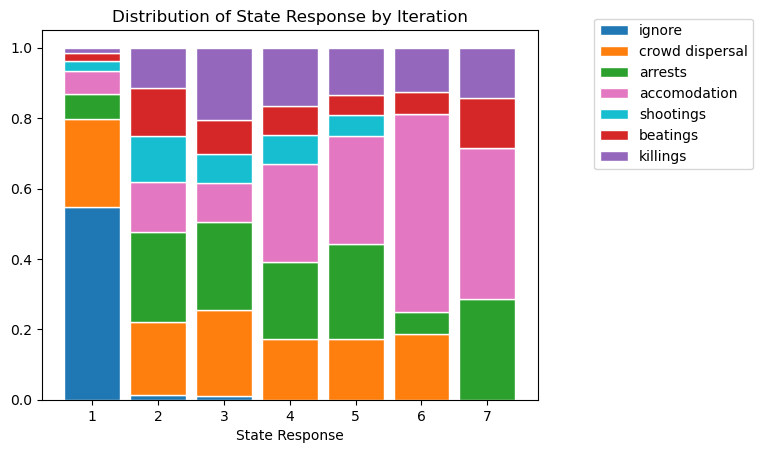

In [100]:
# plotting stacked graph
barWidth = 0.85
names = ('1','2','3','4','5','6','7')
# Create 1/blue Bars
plt.bar(r, [bar[0] for bar in response_bars], color='C0', edgecolor='white', width=barWidth, label='ignore')
# Create 2/orange Bars
plt.bar(r, [bar[1] for bar in response_bars], bottom=response_bars_horizontal[0], color='C1', edgecolor='white', width=barWidth, label='crowd dispersal')
# Create 3/green Bars
plt.bar(r, [bar[2] for bar in response_bars], bottom=[i+j for i,j in zip(response_bars_horizontal[0], response_bars_horizontal[1])], color='C2', edgecolor='white', width=barWidth,  label='arrests')
# Create 4/pink Bars
plt.bar(r, [bar[3] for bar in response_bars], bottom=[i+j+k for i,j,k in zip(response_bars_horizontal[0], response_bars_horizontal[1],response_bars_horizontal[2])], color='C6', edgecolor='white', width=barWidth, label='accomodation')
# Create 5/teal Bars
plt.bar(r, [bar[4] for bar in response_bars], bottom=[i+j+k+l for i,j,k,l in zip(response_bars_horizontal[0], response_bars_horizontal[1], response_bars_horizontal[2], response_bars_horizontal[3])], color='C9', edgecolor='white', width=barWidth, label='shootings')
# Create 6/red Bars
plt.bar(r, [bar[5] for bar in response_bars], bottom=[i+j+k+l+m for i,j,k,l,m in zip(response_bars_horizontal[0], response_bars_horizontal[1], response_bars_horizontal[2], response_bars_horizontal[3], response_bars_horizontal[4])], color='C3', edgecolor='white', width=barWidth, label='beatings')
# Create 7/purple Bars
plt.bar(r, [bar[6] for bar in response_bars], bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(response_bars_horizontal[0], response_bars_horizontal[1], response_bars_horizontal[2], response_bars_horizontal[3], response_bars_horizontal[4], response_bars_horizontal[5])], color='C4', edgecolor='white', width=barWidth, label='killings')
# Custom x axis
plt.xticks(r, names)
plt.xlabel("State Response")
plt.title("Distribution of State Response by Iteration")
plt.legend(bbox_to_anchor=(1.1, 1.05))
#plt.savefig('14_State_response_stack.png', bbox_inches='tight')
plt.show()

### Exporting modified df2 as df3

In [102]:
df3 = df2.copy()

In [103]:
df3.to_csv('df3.csv', index=False)

## Cramers_V  <a class="anchor" id="cramers"></a>

In [104]:
df_cram = df3.copy()

In [105]:
#dropping "duplicate" columns that are represented elsewhere in the df, as well as any target data and "future" data
df_cram.drop(columns=['country','participants_int','protesterdemand1_y','protesterdemand2_y','protesterdemand3_y','protesterdemand4_y','stateresponse1_y','stateresponse2_y','stateresponse3_y','stateresponse4_y','stateresponse5_y','stateresponse6_y','stateresponse7_y', 'start_date','end_date','Violent_Response','accomodation','arrests','beatings','crowd_dispersal','ignore','killings','shootings','first_response','last_response', 'responses_count','protesterviolence','dur_column','dur_column2' ] , inplace=True)

In [106]:
df_cram_e = pd.get_dummies(df_cram, columns=None)

In [107]:
#Cramers V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [108]:
rows= []

for x in df_cram_e:
  col = []
  for y in df_cram_e:
    cramers =cramers_v(df_cram_e[x], df_cram_e[y]) # Cramer's V test defined above
    col.append(round(cramers,2)) # Appending the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df4 = pd.DataFrame(cramers_results, columns =df_cram_e.columns, index =df_cram_e.columns)



df4

,year,labor_wage_dispute,land_farm_issue,police_brutality,political_behavior,price_increases_tax_policy,removal_of_politician,social_restrictions,demands_count,region_Africa,...,new_participants_category_2000-4999,new_participants_category_50-99,new_participants_category_5000-10000,new_participants_category_>10000,hemisphere_northern,hemisphere_southern,season_autumn,season_spring,season_summer,season_winter
year,1.00,0.09,0.12,0.08,0.11,0.12,0.20,0.10,0.15,0.13,...,0.07,0.24,0.11,0.12,0.11,0.11,0.09,0.07,0.07,0.12
labor_wage_dispute,0.09,1.00,0.07,0.10,0.35,0.01,0.10,0.07,0.26,0.02,...,0.01,0.02,0.01,0.06,0.01,0.01,0.01,0.03,0.03,0.01
land_farm_issue,0.12,0.07,1.00,0.03,0.17,0.05,0.05,0.03,0.11,0.00,...,0.01,0.00,0.03,0.03,0.01,0.01,0.01,0.00,0.00,0.00
police_brutality,0.08,0.10,0.03,1.00,0.23,0.06,0.05,0.03,0.14,0.00,...,0.03,0.02,0.02,0.04,0.04,0.04,0.02,0.00,0.01,0.00
political_behavior,0.11,0.35,0.17,0.23,1.00,0.25,0.13,0.13,0.22,0.02,...,0.03,0.00,0.03,0.02,0.00,0.00,0.00,0.01,0.00,0.01
price_increases_tax_policy,0.12,0.01,0.05,0.06,0.25,1.00,0.06,0.05,0.32,0.02,...,0.00,0.01,0.00,0.00,0.03,0.03,0.01,0.00,0.00,0.00
removal_of_politician,0.20,0.10,0.05,0.05,0.13,0.06,1.00,0.06,0.37,0.03,...,0.02,0.00,0.09,0.04,0.00,0.00,0.01,0.00,0.04,0.02
social_restrictions,0.10,0.07,0.03,0.03,0.13,0.05,0.06,1.00,0.16,0.02,...,0.00,0.00,0.02,0.01,0.02,0.02,0.00,0.01,0.01,0.00
demands_count,0.15,0.26,0.11,0.14,0.22,0.32,0.37,0.16,1.00,0.02,...,0.02,0.06,0.06,0.05,0.04,0.04,0.03,0.00,0.03,0.01
region_Africa,0.13,0.02,0.00,0.00,0.02,0.02,0.03,0.02,0.02,1.00,...,0.00,0.23,0.10,0.12,0.31,0.31,0.01,0.02,0.00,0.01


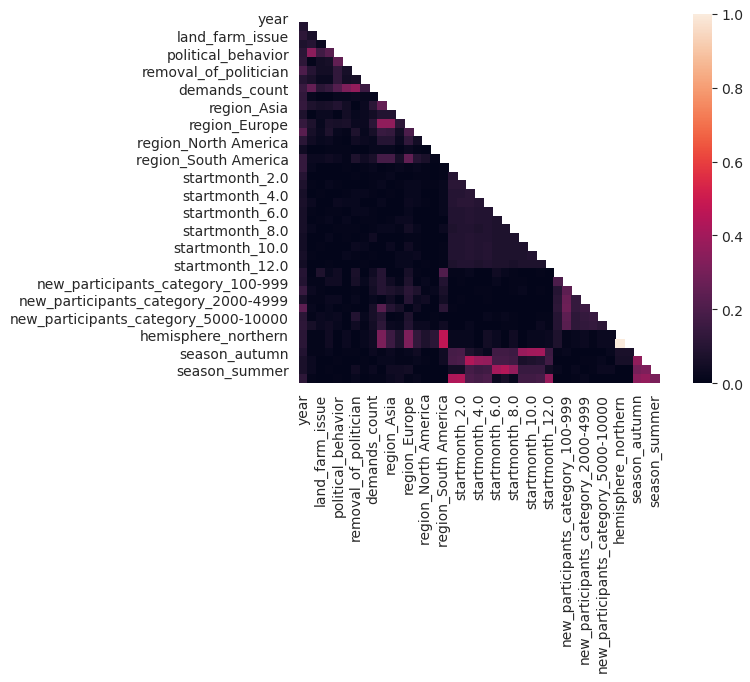

In [109]:
mask = np.zeros_like(df4, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True




with sns.axes_style("white"):
  ax = sns.heatmap(df4, mask=mask,vmin=0., vmax=1, square=True)

plt.show()